In [1]:
%%capture
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas
!pip install sentinelsat
!pip install rasterio
!pip install osgeo
!pip install earthpy

In [11]:
import folium
import geopandas as gpd
from sentinelsat.sentinel import SentinelAPI
import rasterio 
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask
from osgeo import gdal
import earthpy as et
import os
import pandas as pd
from zipfile import ZipFile

In [4]:
# Create Data Folder
current_path = os.getcwd()
data_path = os.path.join(current_path, "data")
os.makedirs(data_path, exist_ok = True)

# Funciones Útiles

In [41]:
def array_to_raster(raster_array, raster_orig, path_to_save = "./output.tif"):
  import numpy as np
  import rasterio
  from rasterio.crs import CRS
  from rasterio.transform import from_origin

  # Add One Dimension(dst.write needs three dimentions)
  raster_array = np.array([raster_array])

  # Get Some Parameters
  dim = raster_array.shape
  height = dim[1]
  width = dim[2]
  dtype = raster_array.dtype

  # Get EPSG code
  epsg = raster_orig.crs.to_epsg()
  crs = CRS.from_epsg(epsg)

  # Get Sizes
  t = raster_orig.transform
  x_size = t[0]
  y_size = -t[4]

  # Get Upper Left Coordinates
  x_westup, y_westup = blue.xy(0,0)

  # Affine Transformation
  transform = from_origin(west = x_westup-5, north = y_westup+5, xsize = x_size, ysize = y_size)

  # Save Raster
  with rasterio.open(path_to_save, "w",
                   driver = "GTiff",
                   height = height,
                   width = width,
                   count = 1,
                   dtype = dtype,
                   crs = crs,
                   transform = transform) as dst:
    dst.write(raster_array)
  
  # Load Raster
  raster_loaded = rasterio.open("./output.tif")
  
  return raster_loaded


def getFeatures(gdf):
  """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
  import json
  return [json.loads(gdf.to_json())['features'][0]['geometry']]

def acervos_co2e(bosque_seleccionado: str, cobertura_copa: float) -> float:
  C = round(cobertura_copa, 3) # La documentación dice un decimal 17.3%
  A = bosques_dict[bosque_seleccionado]["area"] 
  RE = bosques_dict[bosque_seleccionado]["estimador"] 
  acervo_estimado = A*C*RE

  return acervo_estimado

# Descarga de Datos de Sentinel

In [5]:
roi = gpd.read_file('./data/roi_gdlj.geojson')
print(roi.head())

   id                                           geometry
0   1  MULTIPOLYGON (((-103.38683 20.56446, -103.2610...


In [6]:
footprint = None
for i in roi['geometry']:
    footprint = i
    
user = 'davidmacer'
password = 'wFwKeDESv@TCuK8'
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
products = api.query(footprint,
                     date = ('20220701', '20220722'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 10))

In [7]:
gdf = api.to_geodataframe(products)
gdf_sorted = gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
2f149dec-aa03-49aa-8d7a-9067a586e4d5,S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-07-21T17:18:59.024Z, Instrument: MS...",false,2022-07-21 21:54:46,2022-07-21 17:18:59.024,2022-07-21 17:18:59.024,2022-07-22 01:23:50.369,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220721T215446_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220721T215446_A0280...,S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_2...,2f149dec-aa03-49aa-8d7a-9067a586e4d5,"MULTIPOLYGON (((-102.99722 19.79682, -102.9844..."


In [9]:
# Download Sentinel Data
api.download(gdf_sorted.iloc[0]['uuid'])

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

{'Creation Date': datetime.datetime(2022, 7, 22, 1, 24, 25, 126000),
 'Ingestion Date': datetime.datetime(2022, 7, 22, 1, 23, 50, 369000),
 'Online': True,
 'date': datetime.datetime(2022, 7, 21, 17, 18, 59, 24000),
 'downloaded_bytes': 1187100400,
 'footprint': 'POLYGON((-104.03912 20.79755038149346,-102.984436 20.788403082171477,-102.99722 19.796820923140057,-104.04523 19.805495474810392,-104.03912 20.79755038149346))',
 'id': '2f149dec-aa03-49aa-8d7a-9067a586e4d5',
 'md5': 'a5b97f9bf99d5ac9110888005ace6871',
 'path': 'S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_20220721T215446.zip',
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('2f149dec-aa03-49aa-8d7a-9067a586e4d5')/Products('Quicklook')/$value",
 'size': 1187100400,
 'title': 'S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_20220721T215446',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('2f149dec-aa03-49aa-8d7a-9067a586e4d5')/$value"}

In [12]:
# Extract all the contents of zip file in current directory
with ZipFile('S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_20220721T215446.zip', 'r') as zipObj:
   zipObj.extractall()

In [14]:
# Open Bands
bands = r'./S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_20220721T215446.SAFE/GRANULE/L2A_T13QFC_A028066_20220721T173238/IMG_DATA/R10m'
blue = rasterio.open(bands + '/T13QFC_20220721T171859_B02_10m.jp2') 
green = rasterio.open(bands + '/T13QFC_20220721T171859_B03_10m.jp2') 
red = rasterio.open(bands + '/T13QFC_20220721T171859_B04_10m.jp2')
nir = rasterio.open(bands + '/T13QFC_20220721T171859_B08_10m.jp2')

In [15]:
blue.read(1)

array([[[1439, 1493, 1526, ..., 1430, 1410, 1439],
        [1596, 1675, 1950, ..., 1439, 1412, 1437],
        [1768, 1906, 2016, ..., 1464, 1471, 1458],
        ...,
        [1809, 1778, 1728, ..., 1398, 1360, 1380],
        [1586, 1485, 1462, ..., 1401, 1356, 1376],
        [1470, 1640, 1750, ..., 1493, 1378, 1291]]], dtype=uint16)

# Cálculo NDVI 

In [16]:
ndvi = (nir.read().astype(int)-red.read().astype(int))/(nir.read().astype(int)+red.read().astype(int))

In [17]:
print(ndvi.min()), print(ndvi.max())
print(ndvi[0].shape)

-0.6922238192000792
0.7962760131434831
(10980, 10980)


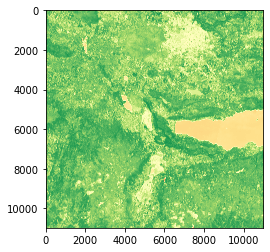

In [18]:
plt.imshow(ndvi[0], cmap='RdYlGn')

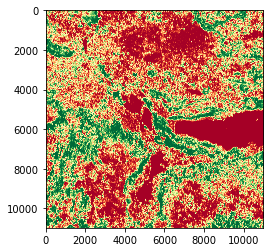

In [19]:
# Discretize NDVI
ndvi[0][ndvi[0] >= 0.5] = 1
ndvi[0][ndvi[0] < 0.5] = 0
plt.imshow(ndvi[0], cmap='RdYlGn')

In [22]:
# NDVI array to raster
raster_load = array_to_raster(ndvi[0], blue)
print(raster_load.read().min()), print(raster_load.read().max())

0.0
1.0


(None, None)

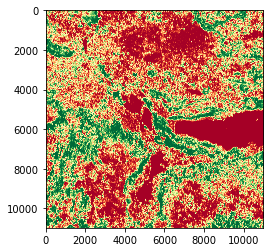

In [23]:
plt.imshow(raster_load.read(1), cmap='RdYlGn')

# Recorte de Bosques Urbanos
Vamos a recortar las zonas dentro de los bosques urbanos usando sus polígonos

In [25]:
bosques = gpd.read_file('./data/bosques_urbanos_jalisco.geojson')
bosques = bosques.to_crs(32613)

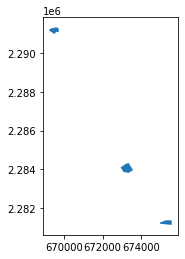

In [26]:
bosques.plot()

In [31]:
# Zonas con vegetación
bosque_gallo = bosques.cx[670000:675000,2282000:2300000]
bosque_avila = bosques.cx[600000:670000,2290000:2500000]
bosque_tlaque = bosques

coords_tlaque = getFeatures(bosque_tlaque)
coords_gallo = getFeatures(bosque_gallo)
coords_avila = getFeatures(bosque_avila)

out_img_tlaque, out_transform = mask(dataset=raster_load, shapes=coords_tlaque, crop=True)
out_img_gallo, out_transform = mask(dataset=raster_load, shapes=coords_gallo, crop=True)
out_img_avila, out_transform = mask(dataset=raster_load, shapes=coords_avila, crop=True)

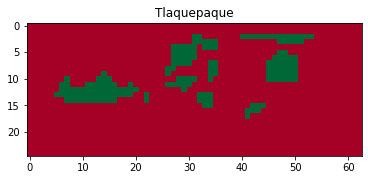

In [47]:
plt.imshow(out_img_tlaque[0], cmap='RdYlGn')
plt.title("Tlaquepaque")
plt.savefig('tlaquepaque.png', bbox_inches='tight')

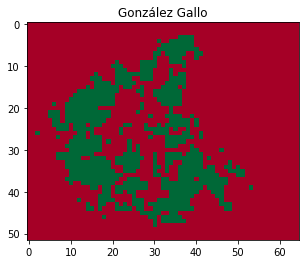

In [48]:
plt.imshow(out_img_gallo[0], cmap='RdYlGn')
plt.title("González Gallo")
plt.savefig('gallo.png', bbox_inches='tight')

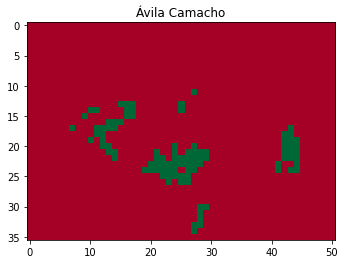

In [49]:
plt.imshow(out_img_avila[0], cmap='RdYlGn')
plt.title("Ávila Camacho")
plt.savefig('avila.png', bbox_inches='tight')

In [36]:
bosques_df = pd.DataFrame(bosques, copy=True)
bosques_df

,id,nombre,desc,area_ha,geometry
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951..."
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203..."
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271..."


In [37]:
area_tlaque = out_img_tlaque[0].mean()
area_gallo = out_img_gallo[0].mean()
area_avila = out_img_avila[0].mean()
area = [area_tlaque, area_gallo, area_avila]
area

[0.10793650793650794, 0.2150887573964497, 0.05337690631808279]

In [38]:
bosques_df["area_copa"] = area
bosques_df

,id,nombre,desc,area_ha,geometry,area_copa
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951...",0.107937
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203...",0.215089
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271...",0.053377


In [39]:
bosques = gpd.GeoDataFrame(bosques_df, copy=True)
bosques

,id,nombre,desc,area_ha,geometry,area_copa
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951...",0.107937
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203...",0.215089
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271...",0.053377


# Cálculo de tCO2e

In [40]:
bosques_dict = {"gonzalez_gallo": {"area": 17.29,
                             "estimador": 161},
          "tlaquepaque": {"area": 10,
                         "estimador": 161},
          "avila_camacho": {"area": 6,
                           "estimador": 161}}

# tCO2e
co2e_tlaque = acervos_co2e(bosque_seleccionado = "tlaquepaque", cobertura_copa = area_tlaque)
co2e_avila = acervos_co2e(bosque_seleccionado = "avila_camacho", cobertura_copa = area_avila)
co2e_gallo = acervos_co2e(bosque_seleccionado = "gonzalez_gallo", cobertura_copa = area_gallo)

print("tC02e para Tlaque:", co2e_tlaque)
print("tC02e para Avila:", co2e_avila)
print("tC02e para Gallo:", co2e_gallo)

tC02e para Tlaque: 173.88000000000002
tC02e para Avila: 51.198
tC02e para Gallo: 598.49335


In [42]:
acervo_co2 = [co2e_tlaque, co2e_gallo, co2e_avila]
bosques_df["acervo_co2"] = acervo_co2
bosques_df

,id,nombre,desc,area_ha,geometry,area_copa,acervo_co2
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951...",0.107937,173.88000
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203...",0.215089,598.49335
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271...",0.053377,51.19800


In [43]:
bosques = gpd.GeoDataFrame(bosques_df, copy=True)
bosques

,id,nombre,desc,area_ha,geometry,area_copa,acervo_co2
0,1,Bosque de Tlaquepaque,Es el espacio público más grande de todo el mu...,None,"MULTIPOLYGON (((674945.335 2281206.874, 674951...",0.107937,173.88000
1,2,Parque González Gallo,Declarada Area Natural Protegida el día 4 de N...,None,"MULTIPOLYGON (((672932.875 2284110.962, 673203...",0.215089,598.49335
2,3,Parque Ávila Camacho,Es uno de los espacios mas pequeños de la red ...,None,"MULTIPOLYGON (((669241.908 2291156.743, 669271...",0.053377,51.19800


In [44]:
bosques.to_file("bosques_urbanos.geojson", driver='GeoJSON')

In [45]:
bosques.to_file("bosques_urbanos.gpkg", layer='bosques', driver="GPKG")